In [1]:
import numpy as np
import pandas as pd
import h5py
import json
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import compress
import os
from calfews_src import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

#results hdf5 file location from CALFEWS simulations
output_folder_sim = 'results/baseline_wy2017/simulation/p0/'
output_file_sim = output_folder_sim + 'results_p19062016.hdf5'
##get model variable names
modelno_sim = pd.read_pickle(output_folder_sim + 'modelno0.pkl')
modelso_sim = pd.read_pickle(output_folder_sim + 'modelso0.pkl')

##Folder to write visualization files
fig_folder = 'results/baseline_wy2017/wavelets/'
os.makedirs(fig_folder, exist_ok=True)

In [2]:
#Set up data for scenario results
simulation = Visualizer(modelso_sim.district_list, modelso_sim.private_list, modelso_sim.city_list, modelso_sim.contract_list, modelso_sim.waterbank_list, modelso_sim.leiu_list)
simulation.get_results_sensitivity_number(output_file_sim, 19062016, 10, 1905, 1)
simulation.set_figure_params()

In [3]:
# get water year sampler
year = simulation.values.shasta_Q.index.year
month = simulation.values.shasta_Q.index.month
wateryear = year.values
wateryear[month >= 10] += 1

In [4]:
print(list(simulation.values.keys()))
datDaily = simulation.values

# cumulative over water year, for non-cumulative variables like flow
datAnnual_cumulative = datDaily.groupby(wateryear).sum()
# max over water year, for cumulative variables like snow
datAnnual_max = datDaily.groupby(wateryear).max()

['shasta_S', 'shasta_R', 'shasta_R_to_delta', 'shasta_available_storage', 'shasta_outflow_release', 'shasta_days_til_full', 'shasta_Q', 'shasta_SNPK', 'shasta_downstream', 'shasta_fnf', 'oroville_S', 'oroville_R', 'oroville_R_to_delta', 'oroville_available_storage', 'oroville_outflow_release', 'oroville_days_til_full', 'oroville_Q', 'oroville_SNPK', 'oroville_downstream', 'oroville_fnf', 'yuba_S', 'yuba_R', 'yuba_R_to_delta', 'yuba_available_storage', 'yuba_outflow_release', 'yuba_days_til_full', 'yuba_Q', 'yuba_SNPK', 'yuba_downstream', 'yuba_fnf', 'folsom_S', 'folsom_R', 'folsom_R_to_delta', 'folsom_available_storage', 'folsom_outflow_release', 'folsom_days_til_full', 'folsom_Q', 'folsom_SNPK', 'folsom_fnf', 'newmelones_S', 'newmelones_R', 'newmelones_R_to_delta', 'newmelones_Q', 'newmelones_SNPK', 'newmelones_downstream', 'newmelones_fnf', 'donpedro_S', 'donpedro_R', 'donpedro_R_to_delta', 'donpedro_Q', 'donpedro_SNPK', 'donpedro_downstream', 'donpedro_fnf', 'exchequer_S', 'excheque

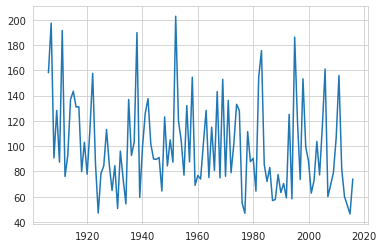

In [6]:
# plot shasta snow
plt.plot(datAnnual_max.oroville_SNPK)

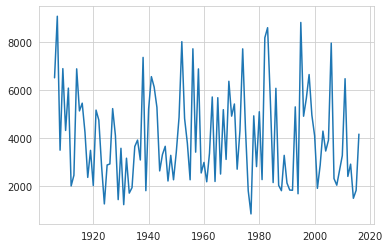

In [7]:
# plot shasta inflow
plt.plot(datAnnual_cumulative.oroville_Q)

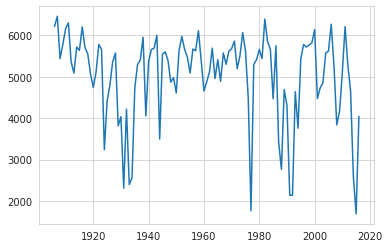

In [8]:
# plot delta pumping
plt.plot(datAnnual_cumulative.delta_HRO_pump + datAnnual_cumulative.delta_TRP_pump)

In [9]:
### function for plotting at wavelet spectrum (adapted from http://regeirk.github.io/pycwt/tutorial.html)
from __future__ import division
import numpy
from matplotlib import pyplot
import pycwt as wavelet
from pycwt.helpers import find

def plot_wavelet(dat, time, title, units, noise='white'):
    
    # We also create a time array in years.
    N = dat.size
    t = time
    t0 =time[0]
    dt = 1  # In years

    # # We write the following code to detrend and normalize the input data by its
    # # standard deviation. Sometimes detrending is not necessary and simply
    # # removing the mean value is good enough. However, if your dataset has a well
    # # defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
    # # above mentioned website, it is strongly advised to perform detrending.
    # # Here, we fit a one-degree polynomial function and then subtract it from the
    # # original data.
    # p = numpy.polyfit(t - t0, dat, 1)
    # dat_notrend = dat - numpy.polyval(p, t - t0)
    # std = dat_notrend.std()  # Standard deviation
    # var = std ** 2  # Variance
    # dat_norm = dat_notrend / std  # Normalized dataset
    dat_norm = (dat - dat.mean()) / dat.std()
    var = dat_norm.var()

    # The next step is to define some parameters of our wavelet analysis. We
    # select the mother wavelet, in this case the Morlet wavelet with
    # :math:`\omega_0=6`.
    mother = wavelet.Morlet(6)
    s0 = 2 * dt  # Starting scale
    dj = 1 / 12  # Twelve sub-octaves per octaves
    J = 4 / dj  # Seven powers of two with dj sub-octaves
    
    if noise == 'red':
        alpha, _, _ = wavelet.ar1(dat_norm)  # Lag-1 autocorrelation for red noise
    elif noise == 'white':
        alpha=0

    # The following routines perform the wavelet transform and inverse wavelet
    # transform using the parameters defined above. Since we have normalized our
    # input time-series, we multiply the inverse transform by the standard
    # deviation.
    wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)
    iwave = wavelet.icwt(wave, scales, dt, dj, mother) #* std

    # print(wave.shape)
    # print(scales.shape)
    # print(freqs.shape)
    # print(iwave.shape)
    # print(iwave.real/dat_norm)
#     fig = plt.figure()
#     plt.scatter(iwave.real, dat_norm)
#     plt.show()

    # We calculate the normalized wavelet and Fourier power spectra, as well as
    # the Fourier equivalent periods for each wavelet scale.
    power = (numpy.abs(wave)) ** 2
    fft_power = numpy.abs(fft) ** 2
    period = 1 / freqs

    # We could stop at this point and plot our results. However we are also
    # interested in the power spectra significance test. The power is significant
    # where the ratio ``power / sig95 > 1``.
    signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                             significance_level=0.95,
                                             wavelet=mother)
    sig95 = numpy.ones([1, N]) * signif[:, None]
    sig95 = power / sig95

    # Then, we calculate the global wavelet spectrum and determine its
    # significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales  # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                            significance_level=0.95, dof=dof,
                                            wavelet=mother)

    # We also calculate the scale average between 2 years and 8 years, and its
    # significance level.
    Cdelta = mother.cdelta

    sel_2_8 = find((period >= 2) & (period <= 8))
    scale_avg_2_8 = (scales * numpy.ones((N, 1))).transpose()
    scale_avg_2_8 = power / scale_avg_2_8  # As in Torrence and Compo (1998) equation 24
    scale_avg_2_8 = var * dj * dt / Cdelta * scale_avg_2_8[sel_2_8, :].sum(axis=0)
    scale_avg_signif_2_8, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                 significance_level=0.95,
                                                 dof=[scales[sel_2_8[0]],
                                                      scales[sel_2_8[-1]]],
                                                 wavelet=mother)

    # Finally, we plot our results in four different subplots containing the
    # (i) original series anomaly and the inverse wavelet transform; (ii) the
    # wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
    # (iv) the range averaged wavelet spectrum. In all sub-plots the significance
    # levels are either included as dotted lines or as filled contour lines.

    # Prepare the figure
    pyplot.close('all')
    pyplot.ioff()
    figprops = dict(figsize=(11, 8), dpi=72)
    fig = pyplot.figure(**figprops)

    # First sub-plot, the original time series anomaly and inverse wavelet
    # transform.
    ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
    ax.plot(t, iwave.real, '-', linewidth=1, color=[0.5, 0.5, 0.5])
    ax.plot(t, dat_norm, 'k', linewidth=1.5)
    ax.set_title('a) {}'.format(title))
    ax.set_ylabel(r'{} [{}]'.format(title, units))

    # Second sub-plot, the normalized wavelet power spectrum and significance
    # level contour lines and cone of influece hatched area. Note that period
    # scale is logarithmic.
    bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
    bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
                extend='both', cmap=pyplot.cm.viridis)
    extent = [t.min(), t.max(), 0, max(period)]
    bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
               extent=extent)
    bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                               t[:1] - dt, t[:1] - dt]),
            numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                               numpy.log2(period[-1:]), [1e-9]]),
            'k', alpha=0.3, hatch='x')
    bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(title, mother.name))
    bx.set_ylabel('Period (years)')
    #
    Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                               numpy.ceil(numpy.log2(period.max())))
    bx.set_yticks(numpy.log2(Yticks))
    bx.set_yticklabels(Yticks)

    # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
    # noise spectra. Note that period scale is logarithmic.
    cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
    cx.plot(glbl_signif, numpy.log2(period), 'k--')
    cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
    cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
            linewidth=1.)
    cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
    cx.set_title('c) Global Wavelet Spectrum')
    cx.set_xlabel(r'Power [({})^2]'.format(units))
    cx.set_xlim([0, glbl_power.max() + var])
    cx.set_ylim(numpy.log2([period.min(), period.max()]))
    cx.set_yticks(numpy.log2(Yticks))
    cx.set_yticklabels(Yticks)
    pyplot.setp(cx.get_yticklabels(), visible=False)

    # Fourth sub-plot, the scale averaged wavelet spectrum.
    dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
    dx.axhline(scale_avg_signif_2_8, color='k', linestyle='--', linewidth=1.)
    dx.plot(t, scale_avg_2_8, 'k-', linewidth=1.5)
    dx.set_title('d) {}--{} year scale-averaged power'.format(2,8))
    dx.set_xlabel('Time (year)')
    dx.set_ylabel(r'Average variance [{}]'.format(units))
    ax.set_xlim([t.min(), t.max()])
#     plt.savefig(dir_figs + 'fig_sweWaveletSynthFeb.jpg', bbox_inches='tight', dpi=1200)

    pyplot.show()

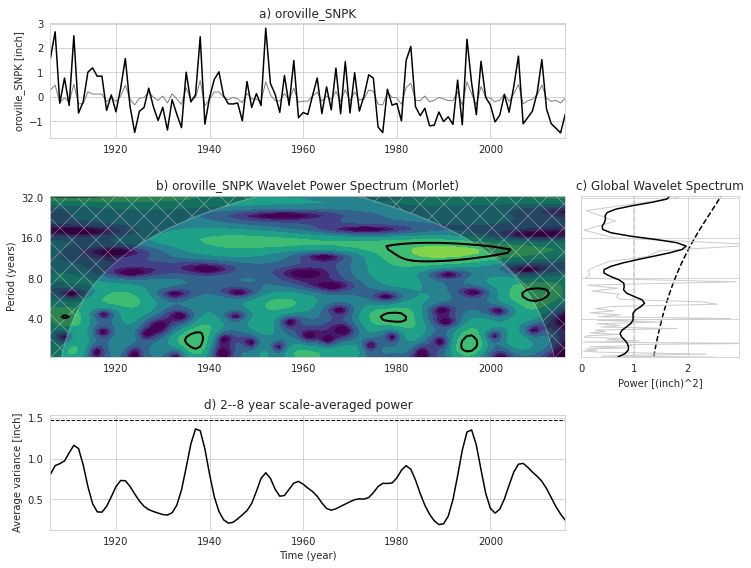

In [13]:
### now plot wavelet spectrum of different time series
series = datAnnual_max.oroville_SNPK
plot_wavelet(series.values, series.index, 'oroville_SNPK', 'inch', 'white')

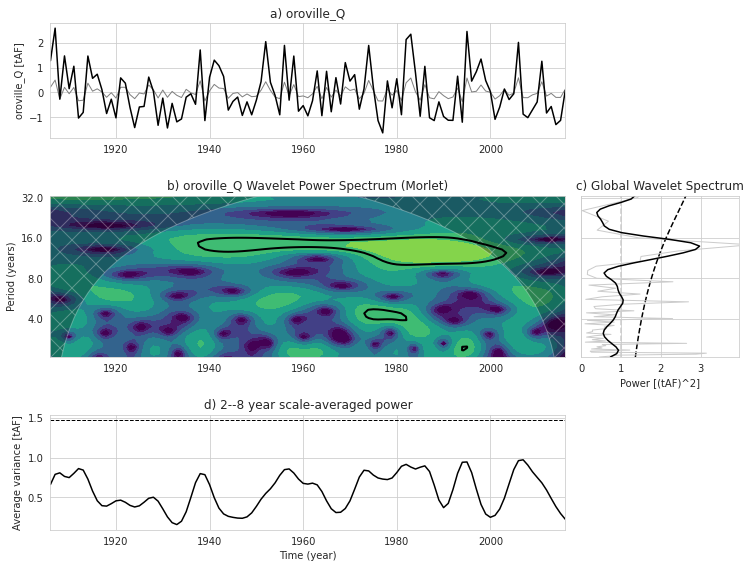

In [17]:
series = datAnnual_cumulative.oroville_Q
plot_wavelet(series.values, series.index, 'oroville_Q', 'tAF', 'white')

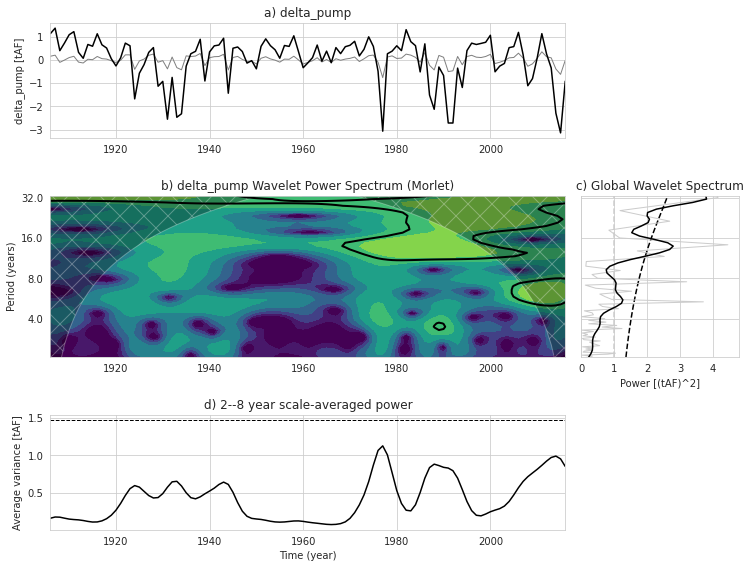

In [18]:
series = datAnnual_cumulative.delta_HRO_pump + datAnnual_cumulative.delta_TRP_pump
plot_wavelet(series.values, series.index, 'delta_pump', 'tAF', 'white')